In [1]:
!pip install pyspark findspark nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import re 
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050').set('spark.serializer', 'org.apache.spark.serializer.KryoSerializer')\
                  .set('spark.dynamicAllocation.enabled', 'true')\
                  .set('spark.shuffle.service.enabled', 'true') #трекер, чтобы возвращать ресурсы
sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

Как проще всего создать RDD? Вызвать метод и передать ему нужный объект

In [4]:
first_rdd  = sc.parallelize(range(1000000))

In [5]:
first_rdd.getNumPartitions()

2

А можно ли менять количество партиций? Да, для этого есть два метода: repartition() и coalesce(). Первый используется для увеличения и уменьшения количества партиций, второй только для снижения, прчем coalesce будет работать эффективнее. Много партиций - дольше будет считаться, но если данных много, то обязательно нужно

repartition()` всегда приводит к равномерному перераспределению данных, что ведет к shuffle. Если Вы уменьшаете число партиций, то стоит использовать `coalesce()`, который может избежать shuffle

In [6]:
first_rdd = first_rdd.repartition(5)
print(first_rdd.getNumPartitions())

5


In [7]:
first_rdd = first_rdd.repartition(2)
print(first_rdd.getNumPartitions())

2


In [8]:
first_rdd = first_rdd.coalesce(1)
print(first_rdd.getNumPartitions())

1


In [9]:
a = %time first_rdd.sum()

CPU times: user 64.2 ms, sys: 15.1 ms, total: 79.3 ms
Wall time: 7.09 s


Посмотрим на время выполнения для разного числа партиций

In [10]:
result = []
first_rdd  = sc.parallelize(range(5000000))
for partition in range(1, 30):
    first_rdd = first_rdd.repartition(partition)
    time = %timeit -o  -n 1 -r 1 first_rdd.sum()
    time = time.best
    result.append((partition, time))

6.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.44 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.59 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.04 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.78 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.77 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.08 s ± 0 ns per loop (mean ± std. dev.

In [11]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

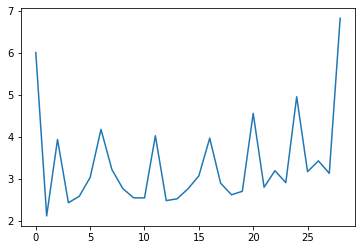

In [12]:
plt.plot([res[1] for res in result])

А почему лучший результат при небольшом количестве партиций?

In [13]:
import multiprocessing

multiprocessing.cpu_count()

2

Из list также можно создавать RDD

In [14]:
bad_list = [1, 2, 3, 'a', 10, 'b']

In [15]:
bad_list_rdd = sc.parallelize(bad_list)

In [16]:
bad_list_rdd.collect()

[1, 2, 3, 'a', 10, 'b']

Еще можно создать RDD через textFile и wholeTextFiles

In [17]:
text_rdd = sc.textFile('spark_text.txt')

In [18]:
text_rdd.take(1)

['Apache Spark is an open-source unified analytics engine for large-scale data processing. Spark provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. Originally developed at the University of California, Berkeley AMPLab, the Spark codebase was later donated to the Apache Software Foundation, which has maintained it since.']

wholeTextFiles создает PairRDD в формате key-value, где ключ - имя файла, а значения - то, что находистя в файле. Имена файлов считываются из папки через wholeTextFiles

In [21]:
dirPath = 'files'
os.mkdir(dirPath)
with open(os.path.join(dirPath, "1.txt"), "w") as file1:
    _ = file1.write("[1 2 3]")
with open(os.path.join(dirPath, "2.txt"), "w") as file2:
    _ = file2.write("[4 5 6]")
textFiles = sc.wholeTextFiles(dirPath)

In [22]:
textFiles

org.apache.spark.api.java.JavaPairRDD@3691f3cf

In [23]:
textFiles.collect()

[('file:/content/files/1.txt', '[1 2 3]'),
 ('file:/content/files/2.txt', '[4 5 6]')]

У RDD есть стандартно 2 типа методов - actions и transformations

**Actions**

Начнем с actions, то есть того, что заставит посчитать

In [24]:
first_rdd = first_rdd.coalesce(2)

In [25]:
first_rdd.sum()

12499997500000

In [26]:
first_rdd.min(), first_rdd.max()

(0, 4999999)

In [27]:
first_rdd.first()

406740

In [28]:
first_rdd.take(2)

[406740, 406741]

In [29]:
first_rdd.count()

5000000

In [30]:
a = first_rdd.collect()

In [31]:
first_rdd.saveAsTextFile, first_rdd.saveAsPickleFile

(<bound method RDD.saveAsTextFile of CoalescedRDD[165] at coalesce at <unknown>:0>,
 <bound method RDD.saveAsPickleFile of CoalescedRDD[165] at coalesce at <unknown>:0>)

In [32]:
first_rdd.reduce(lambda x, y: x + y)

12499997500000

Если нужно получить небольшое число записей на драйвер и, при этом, сохранить распределение, то лучше сделать выборку

In [33]:
first_rdd.takeSample(withReplacement=False, num=5, seed=5757)

[140278, 3814479, 4519432, 580019, 2341229]

**Transformations**

Это просто трансформации, которые не будут вычисляться до вызова actions

In [34]:
a = sc.parallelize([1, 2, 3])
b = sc.parallelize([2, 3, 4])

In [35]:
c = a + b

In [36]:
c.collect()

[1, 2, 3, 2, 3, 4]

filter

In [37]:
text_rdd.count()

100

In [38]:
text_rdd.filter(lambda x: x != '').count()

60

In [39]:
text_rdd = text_rdd.filter(lambda x: x != '')

map

In [40]:
stop_words = stopwords.words("english")
stop_words = set(stop_words)

In [41]:
def mapper_text(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words_with_value = [(word.lower(), 1) for word in words 
                        if word not in stop_words]
    return words_with_value

In [42]:
text_rdd.map(mapper_text).take(1)

[[('apache', 1),
  ('spark', 1),
  ('opensource', 1),
  ('unified', 1),
  ('analytics', 1),
  ('engine', 1),
  ('largescale', 1),
  ('data', 1),
  ('processing', 1),
  ('spark', 1),
  ('provides', 1),
  ('interface', 1),
  ('programming', 1),
  ('entire', 1),
  ('clusters', 1),
  ('implicit', 1),
  ('data', 1),
  ('parallelism', 1),
  ('fault', 1),
  ('tolerance', 1),
  ('originally', 1),
  ('developed', 1),
  ('university', 1),
  ('california', 1),
  ('berkeley', 1),
  ('amplab', 1),
  ('spark', 1),
  ('codebase', 1),
  ('later', 1),
  ('donated', 1),
  ('apache', 1),
  ('software', 1),
  ('foundation', 1),
  ('maintained', 1),
  ('since', 1)]]

flatMap

Попробуем применить map и flatMap

In [43]:
text_rdd.map(mapper_text).count()

60

In [44]:
text_rdd.flatMap(mapper_text).count()

1921

Как так?

In [45]:
text_rdd.map(mapper_text).map(len).sum()

1921

вроде понятно что случилось, но давайте на игрушечном примере

In [46]:
simple_example = sc.parallelize([[1, 2, 3], [2, 3, 4], [4, 5, 6]])

In [47]:
def pow_elements(elements):
    return [x**2 for x in elements]

In [48]:
simple_example.map(pow_elements).collect()

[[1, 4, 9], [4, 9, 16], [16, 25, 36]]

In [49]:
simple_example.flatMap(pow_elements).collect()

[1, 4, 9, 4, 9, 16, 16, 25, 36]

groupByKey

In [50]:
text_rdd = text_rdd.flatMap(mapper_text)

In [51]:
text_rdd.groupByKey().mapValues(len).collect()

[('opensource', 1),
 ('unified', 2),
 ('analytics', 5),
 ('engine', 4),
 ('provides', 10),
 ('programming', 9),
 ('entire', 1),
 ('clusters', 2),
 ('implicit', 1),
 ('fault', 1),
 ('tolerance', 1),
 ('originally', 3),
 ('developed', 2),
 ('university', 1),
 ('codebase', 1),
 ('readonly', 2),
 ('multiset', 1),
 ('items', 2),
 ('faulttolerant', 1),
 ('way2', 1),
 ('api', 14),
 ('in', 7),
 ('primary', 1),
 ('use', 9),
 ('encouraged3', 1),
 ('even', 5),
 ('though', 1),
 ('technology', 2),
 ('2012', 1),
 ('response', 2),
 ('limitations', 1),
 ('forces', 1),
 ('particular', 1),
 ('programs', 3),
 ('read', 1),
 ('input', 2),
 ('disk', 3),
 ('reduce', 3),
 ('results', 2),
 ('store', 1),
 ('working', 1),
 ('set', 5),
 ('offers', 3),
 ('deliberately', 1),
 ('form', 2),
 ('memory8', 1),
 ('facilitates', 1),
 ('iterative', 2),
 ('algorithm', 1),
 ('visit', 1),
 ('multiple', 4),
 ('ie', 1),
 ('databasestyle', 1),
 ('querying', 2),
 ('latency', 2),
 ('may', 2),
 ('several', 1),
 ('orders', 1),
 ('ma

sortByKey

In [52]:
text_rdd.groupByKey().mapValues(len).sortByKey().collect()

[('10', 1),
 ('11', 1),
 ('16', 1),
 ('1ms', 1),
 ('1x', 1),
 ('20', 1),
 ('2009', 1),
 ('2012', 1),
 ('23', 1),
 ('24', 1),
 ('2x', 3),
 ('50', 1),
 ('5g', 1),
 ('a', 4),
 ('able', 1),
 ('abstraction', 6),
 ('abstracts', 1),
 ('according', 1),
 ('accumulators', 1),
 ('achieved', 1),
 ('across', 5),
 ('acyclic', 1),
 ('added', 2),
 ('addition', 1),
 ('additional', 1),
 ('advantage', 4),
 ('advantages', 1),
 ('afforded', 1),
 ('aggregation', 1),
 ('aggregations', 1),
 ('algorithm', 1),
 ('algorithms', 7),
 ('all', 1),
 ('allocating', 1),
 ('allowing', 3),
 ('allows', 2),
 ('alluxio', 1),
 ('almost', 1),
 ('alone', 1),
 ('alongside', 1),
 ('als', 1),
 ('also', 15),
 ('alternating', 1),
 ('although', 1),
 ('amazon', 3),
 ('among', 2),
 ('amplab', 3),
 ('analysis', 2),
 ('analysts', 1),
 ('analytics', 5),
 ('anonymous', 1),
 ('apache', 56),
 ('apex', 1),
 ('api', 14),
 ('api27', 1),
 ('api67', 1),
 ('apis', 3),
 ('apple', 1),
 ('application', 8),
 ('applications', 5),
 ('applied', 1),
 ('a

И так на самом деле много методов, но предалагаю написать подсчет частоты слов и сделаем это в стиле программ на java

In [53]:
text_rdd = sc.textFile('spark_text.txt')

In [54]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text)\
                 .groupByKey()\
                 .mapValues(len)\
                 .sortBy(lambda x: x[1], ascending=False)\
                 .collect()

In [55]:
result[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

Забыли про reduceByKey

In [56]:
text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(lambda x, y: x + y)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

[('spark', 110),
 ('apache', 56),
 ('data', 44),
 ('streaming', 36),
 ('distributed', 23),
 ('processing', 19),
 ('sql', 17),
 ('learning', 15),
 ('rdd', 15),
 ('also', 15)]

Стоит заметить, что `groupByKey()` предполагает перемещение всех записей с одним ключом на один экзекьютор. В случае очень скошенных распределений это может привести к падению экзекьютора с OOM. Поэтому всегда при группировках стоит подумать об использовании `reduceByKey()`.

Так, на лекции было что-то про count, который не делает shuffle да и вообще можно проще написать?

In [57]:
def mapper_text_simple(text):
    clean_text = re.sub(rf"[{string.punctuation}]", "", text)
    words = nltk.word_tokenize(clean_text)
    words = [word.lower() for word in words 
                        if word not in stop_words]
    return words

In [58]:
result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)
print(result[:10])

[('spark', 110), ('apache', 56), ('data', 44), ('streaming', 36), ('distributed', 23), ('processing', 19), ('sql', 17), ('rdd', 15), ('learning', 15), ('also', 15)]


Замеры

In [59]:
%%timeit

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .groupByKey()\
        .mapValues(len)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

1.12 s ± 232 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%%timeit

text_rdd.filter(lambda x: x != '')\
        .flatMap(mapper_text)\
        .reduceByKey(lambda x, y: x + y)\
        .sortBy(lambda x: x[1], ascending=False)\
        .collect()[:10]

1.08 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit

result = text_rdd.filter(lambda x: x != '')\
                 .flatMap(mapper_text_simple)\
                 .countByValue()
result = sorted(result.items(), key=lambda x: x[1], reverse=True)[:10]

177 ms ± 37.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Join'ы**

Тут просто на игрушечном примере пощупаем данную операцию

In [62]:
rdd_a = sc.parallelize([
                        ('a', [1, 2]),
                        ('b', [2, 4])])

rdd_b = sc.parallelize([
                        ('a', [10]),
                        ('c', [11])])

In [63]:
rdd_a.join(rdd_b).collect()

[('a', ([1, 2], [10]))]

In [64]:
rdd_a.leftOuterJoin(rdd_b).collect()

[('b', ([2, 4], None)), ('a', ([1, 2], [10]))]

In [65]:
rdd_a.fullOuterJoin(rdd_b).collect()

[('b', ([2, 4], None)), ('c', (None, [11])), ('a', ([1, 2], [10]))]

**Домашнее задание 1**

Посчитать количество рейтингов больше 4 для каждого фильма и вывести фильмы в порядке убывания количества этих оценок (можно вывести топ 10)

Файл можете взять из прошлого домашнего задания + сохраните результат на диск

In [66]:
with open('user_ratedmovies.dat', 'rb') as f:
    data = f.readlines()
headers = data[0].decode().split('\t')[:3]
data = [row.decode().split('\t')[:3] for row in data[1:]]

In [77]:
import pandas as pd
import numpy as np
pd.DataFrame(columns=headers, data=np.array(data).astype(np.float)).query("rating>4")\
                                    .groupby('movieID').count()\
                                    .sort_values(by='rating', ascending=False)\
                                    .head(10)

<ipython-input-77-8a6dd900f7cc>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pd.DataFrame(columns=headers, data=np.array(data).astype(np.float)).query("rating>4")\


,userID,rating
movieID,,
2571.0,900,900
318.0,887,887
296.0,878,878
2959.0,828,828
4993.0,756,756
7153.0,719,719
5952.0,697,697
858.0,690,690
50.0,688,688


In [67]:
mov_rdd = sc.parallelize(data)
type(mov_rdd)

pyspark.rdd.RDD

In [68]:
headers

['userID', 'movieID', 'rating']

In [69]:
def mapper(x):
    return (int(x[1]), float(x[2]))

In [80]:
res = mov_rdd.map(mapper)\
       .filter(lambda x: x[1] > 4)\
       .groupByKey()\
       .mapValues(len)\
       .sortBy(lambda x: x[1], ascending=False)

In [81]:
res.collect()[:10]

[(2571, 900),
 (318, 887),
 (296, 878),
 (2959, 828),
 (4993, 756),
 (7153, 719),
 (5952, 697),
 (858, 690),
 (50, 688),
 (2858, 680)]

In [82]:
res.saveAsPickleFile('mov_res')

**Домашнее задание 2**

В этом задании у вас есть файл с обученным word2vec на произведении Достоевского Преступление и наказание. Файл - list, каждый элемент которого слово и его вектор в формате ('word', [vector]). Необходимо для каждого слова собрать список его top 10 похожих слов по косинусной метрике
Результат также сохраните на диск и выведите синонимы для слова 'топор' и 'деньга'.
Файл в пикле, так что для считывания воспользуйтесь не spark, можете взять любимый pandas

Файл не очень уж и маленький, рекомендую сначала написать код на кошках/собачках, а потом уже на всем, так как ядра 2, считаться будет очень долго.
В качестве одного из вариантов можете рассмотреть метод cartesian

In [97]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
  return dot(a, b)/(norm(a)*norm(b))

In [103]:
import pickle

data = pd.read_pickle('w2v_vectors.pickle')
data[0]

('это',
 [0.14321378,
  -0.80575335,
  -0.49581036,
  -0.06394294,
  -1.2238435,
  -0.44410643,
  0.49273458,
  0.17389631,
  -0.27776885,
  0.50880307,
  -0.07283105,
  0.72964376,
  1.1526197,
  0.94315845,
  -1.0720603,
  -0.235505,
  1.2034348,
  -0.3744024,
  -0.36203885,
  -0.07914155,
  0.3772516,
  -0.878622,
  -0.927112,
  0.73365724,
  0.107223585,
  -0.39829564,
  0.61899257,
  0.29151887,
  1.013499,
  0.03111156])

In [113]:
vec_rdd = sc.parallelize(data)

In [116]:
vec_rdd = vec_rdd.cartesian(vec_rdd)\
                  .map(lambda x: (x[0][0], (x[1][0], cos_sim(x[0][1], x[1][1]))))\
                  .filter(lambda x: x[0] != x[1][0])\
                  .groupByKey()\
                  .mapValues(list)\
                  .map(lambda x: (x[0], sorted(x[1], key=lambda x: x[1], reverse=True)[:10]))

In [117]:
vec_rdd.filter(lambda x: x[0] in ('топор', 'деньга')).collect()

[('топор',
  [('левый', 0.92365247),
   ('старуха', 0.922432),
   ('колено', 0.920666),
   ('побежать', 0.9120595),
   ('ломать', 0.91023904),
   ('бросить', 0.90634286),
   ('схватить', 0.902411),
   ('обнять', 0.89990807),
   ('бить', 0.89854604),
   ('положить', 0.89723605)]),
 ('деньга',
  [('вещь', 0.9063148),
   ('отдать', 0.8706483),
   ('убить', 0.842027),
   ('значит', 0.83862835),
   ('известно', 0.8266707),
   ('отец', 0.81461805),
   ('получить', 0.8137906),
   ('ограбить', 0.8044243),
   ('копейка', 0.8012078),
   ('полечка', 0.78048515)])]

In [118]:
vec_rdd.saveAsPickleFile('w2v_res')